In [4]:
import numpy as np
import pandas as pd

from minisom import MiniSom
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
rng = np.random.RandomState(42)

In [5]:
train_df = pd.read_csv(r'C:\Users\ixz407\OneDrive - University of Birmingham\Dissertation\Machine Learning\Dissertation\Tables\bnpl_train.csv')
test_df = pd.read_csv(r'C:\Users\ixz407\OneDrive - University of Birmingham\Dissertation\Machine Learning\Dissertation\Tables\bnpl_test.csv')
val_df = pd.read_csv(r'C:\Users\ixz407\OneDrive - University of Birmingham\Dissertation\Machine Learning\Dissertation\Tables\bnpl_val.csv')
target_col = "default_flag"

In [6]:
print(train_df.shape, test_df.shape, val_df.shape)
print(train_df.head(),test_df.head(), val_df.head())
print("Train nulls in target:", train_df["default_flag"].isna().sum())
print("Train class distribution:\n", train_df["default_flag"].value_counts(normalize=True))

(595, 16) (199, 16) (199, 16)
   failed_traditional_credit  external_repayment_loans  \
0                          1                         1   
1                          0                         0   
2                          0                         0   
3                          0                         0   
4                          0                         1   

   credit_card_interest_incidence  default_flag  bnpl_usage_frequency  \
0                               0             0             -0.730258   
1                               0             0              1.319109   
2                               0             0              0.408279   
3                               1             0             -1.641088   
4                               1             0              0.408279   

   financial_stress_score  credit_limit_utilisation  \
0               -1.246089                 -1.746734   
1                0.529472                 -0.222965   
2                

In [7]:
X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]
print("X_train shape:", X_train.shape, X_train.head())
print("y_train shape:", y_train.shape, y_train.head())
X_test = test_df.drop(columns=[target_col])
y_test = test_df[target_col]
print("X_test shape:", X_test.shape, X_test.head())
print("y_test shape:", y_test.shape, y_test.head())
X_val = val_df.drop(columns=[target_col])
y_val = val_df[target_col]
print("X_val shape:", X_val.shape, X_val.head())
print("y_val shape:", y_val.shape, y_val.head())

X_train shape: (595, 15)    failed_traditional_credit  external_repayment_loans  \
0                          1                         1   
1                          0                         0   
2                          0                         0   
3                          0                         0   
4                          0                         1   

   credit_card_interest_incidence  bnpl_usage_frequency  \
0                               0             -0.730258   
1                               0              1.319109   
2                               0              0.408279   
3                               1             -1.641088   
4                               1              0.408279   

   financial_stress_score  credit_limit_utilisation  \
0               -1.246089                 -1.746734   
1                0.529472                 -0.222965   
2                1.239697                  0.805578   
3                1.594809                 -0.184871

In [8]:
def som_size_heuristic(n_samples: int):
    """Pick a roughly square grid; total units ≈ 5 * sqrt(N_train)."""
    tu = int(max(4, round(5 * np.sqrt(max(1, n_samples)))))
    m = int(round(np.sqrt(tu)))
    n = max(2, int(round(tu / m)))
    return m, n

In [9]:
def fit_som(X_train, m=None, n=None, total_units=None, sigma='auto',
            learning_rate=0.5, neighborhood_function='gaussian',
            num_iteration='auto', random_state=42):
    """
    Fit a MiniSom on TRAIN ONLY.
    - Grid size: choose via (m, n) or total_units, else use heuristic.
    - sigma='auto' -> neighborhood radius starts at ~half the largest grid dim.
    - num_iteration='auto' -> ~10 * n_train updates (tweak if big).
    """
    X = np.asarray(X_train, dtype=float)
    n_samples, n_features = X.shape

    # decide grid shape
    if m is None or n is None:
        if total_units is not None:
            m = int(round(np.sqrt(total_units)))
            n = max(2, int(round(total_units / m)))
        else:
            m, n = som_size_heuristic(n_samples)

    if sigma == 'auto':
        sigma = max(m, n) / 2.0
    if num_iteration == 'auto':
        num_iteration = 10 * n_samples  # lower if dataset is large

    som = MiniSom(x=m, y=n, input_len=n_features, sigma=sigma,
                  learning_rate=learning_rate,
                  neighborhood_function=neighborhood_function,
                  random_seed=random_state)
    som.random_weights_init(X)
    som.train_random(X, num_iteration)
    return som, (m, n)

In [10]:
def som_transform(som, grid_shape, X, one_hot=True, topk=3):
    """
    Turn any X into SOM features:
      - bmu_id, bmu_row, bmu_col
      - distances to the top-k closest units (d1..dk)
      - optional one-hot for bmu_id (adds m*n columns)
    """
    X = np.asarray(X, dtype=float)
    m, n = grid_shape
    num_units = m * n
    W = som.get_weights()  # (m, n, input_len)
    feats = []

    for x in X:
        r, c = som.winner(x)
        bmu_id = r * n + c

        diffs = W - x.reshape(1, 1, -1)
        dists = np.linalg.norm(diffs, axis=2).reshape(-1)  # (m*n,)
        order = np.argsort(dists)
        d_list = [dists[order[i]] for i in range(min(topk, len(order)))]

        row = [bmu_id, r, c] + d_list

        if one_hot:
            oh = np.zeros(num_units, dtype=float)
            oh[bmu_id] = 1.0
            row.extend(oh)

        feats.append(row)

    return np.asarray(feats, dtype=float)


In [11]:
def hstack_features(X, som_feats):
    """Concatenate original features with SOM features."""
    X_arr = np.asarray(X, dtype=float)
    return np.hstack([X_arr, som_feats])

In [12]:
# Fit
som, grid_shape = fit_som(
    X_train,
    m=None, n=None, total_units=None,     # or set total_units=100 for a 10x10-ish map
    sigma='auto',
    learning_rate=0.5,
    neighborhood_function='gaussian',
    num_iteration='auto',                 # ~10 * len(X_train). Lower if slow.
    random_state=42
)



In [13]:
# Transform
som_train = som_transform(som, grid_shape, X_train, one_hot=True, topk=3)
som_val   = som_transform(som, grid_shape, X_val,   one_hot=True, topk=3)
som_test  = som_transform(som, grid_shape, X_test,  one_hot=True, topk=3)

In [14]:
# Stack original + SOM features
X_train_aug = hstack_features(X_train, som_train)
X_val_aug   = hstack_features(X_val,   som_val)
X_test_aug  = hstack_features(X_test,  som_test)

X_train_aug.shape, X_val_aug.shape, X_test_aug.shape

((595, 142), (199, 142), (199, 142))

In [15]:
# --- Cell 5A: SOM diagnostic metrics ---
m, n = grid_shape

qe = som.quantization_error(np.asarray(X_train, dtype=float))
try:
    te = som.topographic_error(np.asarray(X_train, dtype=float))
except AttributeError:
    te = None  # older MiniSom versions might not have this

hits = som.activation_response(np.asarray(X_train, dtype=float))  # shape (m, n)

print({
    "grid_shape": (m, n),
    "quantization_error": float(qe),
    "topographic_error": (float(te) if te is not None else "n/a"),
    "min_hits": int(hits.min()),
    "max_hits": int(hits.max()),
    "empty_units": int((hits == 0).sum()),
})


{'grid_shape': (11, 11), 'quantization_error': 2.8473224697768558, 'topographic_error': 0.02857142857142857, 'min_hits': 0, 'max_hits': 23, 'empty_units': 6}


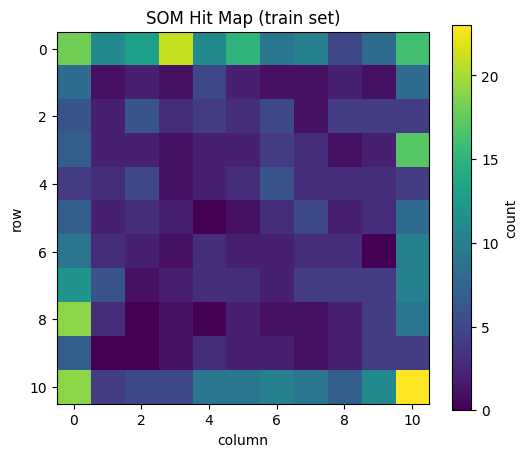

In [16]:

plt.figure(figsize=(6,5))
plt.title("SOM Hit Map (train set)")
plt.imshow(hits, interpolation="nearest")
plt.colorbar(label="count")
plt.xlabel("column"); plt.ylabel("row")
plt.show()

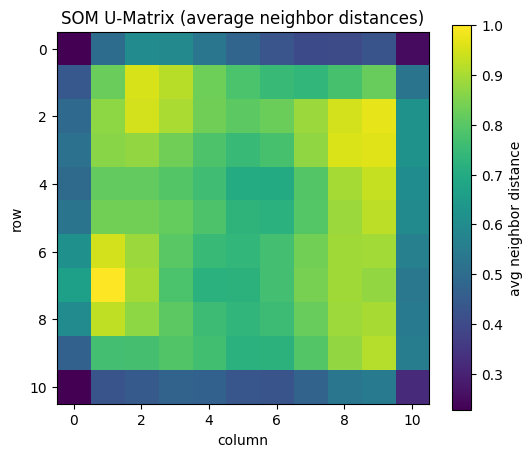

In [17]:
umatrix = som.distance_map()  # shape (m, n), average neighbor distances

plt.figure(figsize=(6,5))
plt.title("SOM U‑Matrix (average neighbor distances)")
plt.imshow(umatrix, interpolation="nearest")
plt.colorbar(label="avg neighbor distance")
plt.xlabel("column"); plt.ylabel("row")
plt.show()

In [29]:
# --- Cell 6: Random Forest (plain, no pipeline) ---

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, confusion_matrix, precision_score, recall_score, classification_report

# 1) Initialize the model
rf = RandomForestClassifier(
    n_estimators=400,          # number of trees
    max_depth=None,            # let trees grow until pure or min_samples_leaf reached
    min_samples_split=2,
    min_samples_leaf=1,
    n_jobs=-1,                  # use all CPU cores
    random_state=42
)

# 2) Fit on the augmented training set
rf.fit(X_train_aug, y_train)

# 3) Predict probabilities
rf_val_proba = rf.predict_proba(X_val_aug)[:, 1]
rf_test_proba = rf.predict_proba(X_test_aug)[:, 1]

# 4) Evaluate performance
rf_metrics = {
    "roc_auc_val": roc_auc_score(y_val, rf_val_proba),
    "avg_precision_val": average_precision_score(y_val, rf_val_proba),
    "f1_val@0.5": f1_score(y_val, (rf_val_proba >= 0.5).astype(int)),
    "roc_auc_test": roc_auc_score(y_test, rf_test_proba),
    "avg_precision_test": average_precision_score(y_test, rf_test_proba),
    "f1_test@0.5": f1_score(y_test, (rf_test_proba >= 0.5).astype(int)),
    "confusion_matrix_test": confusion_matrix(y_test, (rf_test_proba >= 0.5).astype(int)),
    "precision_test": precision_score(y_test, (rf_test_proba >= 0.5).astype(int)),
    "recall_test": recall_score(y_test, (rf_test_proba >= 0.5).astype(int)),
    "classification_report_test": classification_report(y_test, (rf_test_proba >= 0.5).astype(int), target_names=["No Default", "Default"]),
}
rf_metrics


{'roc_auc_val': 0.9892418032786885,
 'avg_precision_val': 0.9309726731601731,
 'f1_val@0.5': 0.72,
 'roc_auc_test': 0.9738729508196721,
 'avg_precision_test': 0.8496976981351982,
 'f1_test@0.5': 0.6666666666666666,
 'confusion_matrix_test': array([[183,   0],
        [  8,   8]]),
 'precision_test': 1.0,
 'recall_test': 0.5,
 'classification_report_test': '              precision    recall  f1-score   support\n\n  No Default       0.96      1.00      0.98       183\n     Default       1.00      0.50      0.67        16\n\n    accuracy                           0.96       199\n   macro avg       0.98      0.75      0.82       199\nweighted avg       0.96      0.96      0.95       199\n'}

In [30]:
thresholds = np.linspace(0.01, 0.99, 99)
scores = [f1_score(y_val, (rf_val_proba >= t).astype(int)) for t in thresholds]
best_t = thresholds[np.argmax(scores)]
print("Best threshold:", best_t)

rf_test_pred_opt = (rf_test_proba >= best_t).astype(int)
rf_test_metrics_opt = {
    "roc_auc_test_opt": roc_auc_score(y_test, rf_test_proba),
    "avg_precision_test_opt": average_precision_score(y_test, rf_test_proba),
    "f1_test_opt@best_t": f1_score(y_test, rf_test_pred_opt),
    "confusion_matrix_test_opt": confusion_matrix(y_test, rf_test_pred_opt),
    "precision_test_opt": precision_score(y_test, rf_test_pred_opt),
    "recall_test_opt": recall_score(y_test, rf_test_pred_opt),
    "classification_report_test_opt": classification_report(y_test, rf_test_pred_opt, target_names=["No Default", "Default"]),
}
rf_test_metrics_opt

Best threshold: 0.34


{'roc_auc_test_opt': 0.9738729508196721,
 'avg_precision_test_opt': 0.8496976981351982,
 'f1_test_opt@best_t': 0.7586206896551724,
 'confusion_matrix_test_opt': array([[181,   2],
        [  5,  11]]),
 'precision_test_opt': 0.8461538461538461,
 'recall_test_opt': 0.6875,
 'classification_report_test_opt': '              precision    recall  f1-score   support\n\n  No Default       0.97      0.99      0.98       183\n     Default       0.85      0.69      0.76        16\n\n    accuracy                           0.96       199\n   macro avg       0.91      0.84      0.87       199\nweighted avg       0.96      0.96      0.96       199\n'}

In [33]:
# --- Cell 7: XGBoost with early stopping ---

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, confusion_matrix, precision_score, recall_score

# 1) Initialize XGBoost
xgb = XGBClassifier(
    n_estimators=1000,           # large enough, early stopping will cut it
    learning_rate=0.05,          # small step size for smoother learning
    max_depth=6,                 # tree depth
    subsample=0.9,                # row sampling
    colsample_bytree=0.9,         # feature sampling
    reg_lambda=1.0,               # L2 regularization
    objective="binary:logistic",
    n_jobs=-1,
    tree_method="hist",           # "gpu_hist" if you have GPU
    random_state=42,
    eval_metric="auc"
)

# 2) Train with early stopping on validation set
xgb.fit(
    X_train_aug, y_train,
    eval_set=[(X_val_aug, y_val)],
    verbose=False
)

# 3) Predict probabilities
xgb_val_proba = xgb.predict_proba(X_val_aug)[:, 1]
xgb_test_proba = xgb.predict_proba(X_test_aug)[:, 1]

# 4) Evaluate at 0.5 threshold
xgb_test_pred = (xgb_test_proba >= 0.5).astype(int)

xgb_metrics = {
    "best_iteration": int(xgb.best_iteration) if hasattr(xgb, "best_iteration") else None,
    "roc_auc_val": roc_auc_score(y_val, xgb_val_proba),
    "avg_precision_val": average_precision_score(y_val, xgb_val_proba),
    "f1_val@0.5": f1_score(y_val, (xgb_val_proba >= 0.5).astype(int)),
    "roc_auc_test": roc_auc_score(y_test, xgb_test_proba),
    "avg_precision_test": average_precision_score(y_test, xgb_test_proba),
    "f1_test@0.5": f1_score(y_test, xgb_test_pred),
    "confusion_matrix_test": confusion_matrix(y_test, xgb_test_pred),
    "precision_test": precision_score(y_test, xgb_test_pred),
    "recall_test": recall_score(y_test, xgb_test_pred)
}

xgb_metrics


{'best_iteration': None,
 'roc_auc_val': 1.0,
 'avg_precision_val': 1.0,
 'f1_val@0.5': 0.9333333333333333,
 'roc_auc_test': 0.9986338797814207,
 'avg_precision_test': 0.9837863270308124,
 'f1_test@0.5': 0.7692307692307693,
 'confusion_matrix_test': array([[183,   0],
        [  6,  10]]),
 'precision_test': 1.0,
 'recall_test': 0.625}

In [34]:
# --- Cell 7A: pick optimal threshold on validation (default: maximize F1) ---
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

def choose_threshold(y_true, y_proba, metric="f1", target_recall=None):
    """
    If metric='f1' -> pick t that maximizes F1 on validation.
    If metric='recall' with target_recall -> pick smallest t achieving that recall.
    """
    thresholds = np.linspace(0.01, 0.99, 99)

    if metric == "f1":
        scores = [f1_score(y_true, (y_proba >= t).astype(int)) for t in thresholds]
        i = int(np.argmax(scores))
        return float(thresholds[i]), float(scores[i])

    if metric == "recall" and target_recall is not None:
        pairs = []
        for t in thresholds:
            pred = (y_proba >= t).astype(int)
            r = recall_score(y_true, pred)
            p = precision_score(y_true, pred, zero_division=0)
            f = f1_score(y_true, pred)
            pairs.append((t, r, p, f))
        # choose the smallest threshold that meets/ exceeds target recall
        viable = [p for p in pairs if p[1] >= target_recall]
        if not viable:
            # fallback to the max recall achieved
            t, r, p, f = max(pairs, key=lambda x: x[1])
            return float(t), float(f)
        t, r, p, f = sorted(viable, key=lambda x: x[0])[0]
        return float(t), float(f)

    raise ValueError("Unsupported option")

# choose best threshold on validation for XGB
xgb_best_t, xgb_val_f1 = choose_threshold(y_val, xgb_val_proba, metric="f1")
print({"xgb_best_threshold": xgb_best_t, "xgb_val_f1": xgb_val_f1})


{'xgb_best_threshold': 0.09, 'xgb_val_f1': 1.0}


In [35]:
# --- Cell 7B: evaluate XGBoost on TEST at the chosen threshold ---
from sklearn.metrics import roc_auc_score, average_precision_score

xgb_test_pred_opt = (xgb_test_proba >= xgb_best_t).astype(int)

xgb_opt_metrics = {
    "threshold": xgb_best_t,
    "roc_auc_test": roc_auc_score(y_test, xgb_test_proba),         # unaffected by threshold
    "avg_precision_test": average_precision_score(y_test, xgb_test_proba),
    "precision_test": precision_score(y_test, xgb_test_pred_opt, zero_division=0),
    "recall_test": recall_score(y_test, xgb_test_pred_opt),
    "f1_test": f1_score(y_test, xgb_test_pred_opt),
    "confusion_matrix_test": confusion_matrix(y_test, xgb_test_pred_opt)
}
xgb_opt_metrics


{'threshold': 0.09,
 'roc_auc_test': 0.9986338797814207,
 'avg_precision_test': 0.9837863270308124,
 'precision_test': 0.9411764705882353,
 'recall_test': 1.0,
 'f1_test': 0.9696969696969697,
 'confusion_matrix_test': array([[182,   1],
        [  0,  16]])}